In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from fiona.crs import from_epsg
from shapely.geometry import Point
import statistics

# Load Data
* df_2016 through df_2018: all park improvement events
* outcomes: includes information about how much debris was picked up or how many plants weeded/planted
* workshops: public workshops and where they occurred
* zipcodes: includes zipcode information of attendees

In [2]:
path_parks= r'M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\RAW\Parks Historical Permits'

In [3]:
parks= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\RAW\NYC_PARKS_DATA\NYCPARKS_ALLSITES.shp")

In [4]:
data_path= r"M:\NY4P Metrics Research 18034\08_RCVD\PfP"

In [5]:
df_2016= pd.read_excel(join(data_path,'2016_IMP_final_ny4p.xlsx')).rename(columns={'Park Name':'SIGNNAME'})
df_2017= pd.read_excel(join(data_path,'2017_IMP_final_ny4p.xls')).rename(columns={'Park Name':'SIGNNAME'})
df_2018= pd.read_excel(join(data_path,'2018_IMP_final_ny4p.xls')).rename(columns={'Park Name':'SIGNNAME'})
outcomes= pd.read_excel(join(data_path,'2016-2018_IMP_Outcomes_ny4p.xlsx')).rename(columns={'Park/ Property: Property Name':'SIGNNAME'})
workshops= pd.read_excel(join(data_path,'2016-2018_Public_Workshops_ny4p.xlsx'))
zipcodes= pd.read_excel(join(data_path,'Workshop_Attendee_Zip_Codes_ny4p.xls'))

In [6]:
perms= pd.read_csv(join(path_parks, '190618_ParksPermits_ADDCOLS.csv'), low_memory=False, index_col=0)

In [7]:
perms['start_date_time']= pd.to_datetime(perms['start_date_time'])
perms['end_date_time']= pd.to_datetime(perms['end_date_time'])

perms['year']= perms['start_date_time'].dt.year
perms['start_time']= perms['start_date_time'].dt.time
perms['end_time']= perms['end_date_time'].dt.time

perms['date']= perms['start_date_time'].dt.date
perms['dow']= perms['start_date_time'].dt.weekday

In [8]:
perms= pd.merge(perms, parks.drop('BOROUGH',axis=1), on='GISPROPNUM',how='inner')

In [9]:
scores= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - Scores\190729_TParks by Acre and Pop.csv")

In [10]:
walksheds= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\190718_10 Min Walksheds with Population_JG\190718_10minwalksheds_pop.csv")

In [11]:
scores= pd.merge(scores, parks.drop('TYPECATEGO',axis=1), on='GISPROPNUM',how='inner')

In [12]:
scores2= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - Scores\190729_TParks by Acre and Pop_NoNormalization.csv")

In [13]:
score_types= ['tp_palmm','tpa_palmm','tppop_palmm','tppopdens_palmm']

In [14]:
scores= pd.merge(scores, walksheds[['GISPROPNUM','Pop_nearPark','PopDens']],on='GISPROPNUM',how='inner')

In [15]:
scores.columns

Index(['GISPROPNUM', 'TYPECATEGO', 'tp_palmm', 'tpa_palmm', 'tppop_palmm',
       'tppopdens_palmm', 'LOCATION', 'COMMUNITYB', 'COUNCILDIS', 'PRECINCT',
       'ZIPCODE', 'BOROUGH', 'ACRES', 'ADDRESS', 'SIGNNAME', 'WATERFRONT',
       'NYS_ASSEMB', 'NYS_SENATE', 'US_CONGRES', 'geometry', 'Pop_nearPark',
       'PopDens'],
      dtype='object')

# Partnership Events by Year
* df_all: concatenates all IMPs for 2016, 2017, and 2018.
* Doesn't include a GISPROPNUM column, so it could be difficult to merge the park dataset with the df_all dataset.

In [16]:
df_all= pd.concat([df_2016,df_2017,df_2018],axis=0,sort=True)

In [17]:
df_all.head()

,Borough,CB,CD,CPI?,Coordinator: Phone,Created Date,Date,Date,Display on Website,Job Type,Parks Equity Initiaitive,Phone for Website,Project Hours,SIGNNAME,Total Volunteer Hours,Total Volunteers
0,Bronx,205.0,14.0,Yes,NaN,NaT,2016-06-10 00:00:00,NaT,NaN,Local Steward Project,NaN,NaN,3.0,Walton Park,120.0,40.0
1,Bronx,205.0,14.0,Yes,NaN,NaT,2016-11-10 00:00:00,NaT,NaN,Local Steward Project,NaN,NaN,3.0,Walton Park,120.0,40.0
2,Queens,403.0,25.0,No,NaN,NaT,2016-01-09 13:42:00,NaT,NaN,Local Steward Project,NaN,NaN,2.0,Travers Park,34.0,17.0
3,Manhattan,111.0,9.0,Yes,NaN,NaT,2016-02-06 09:00:00,NaT,NaN,Other Project,NaN,NaN,3.0,Marcus Garvey Park,54.0,18.0
4,Bronx,202.0,17.0,Yes,NaN,NaT,2016-02-06 10:00:00,NaT,NaN,Other Project,NaN,NaN,3.0,Julio Carballo Fields,81.0,27.0


In [18]:
df_all['Job Type'].value_counts()

Local Steward Project    2624
Other Project             376
Corporate Project         303
Name: Job Type, dtype: int64

In [19]:
print('There are '+ str(df_all['SIGNNAME'].unique().shape[0]) + ' parks with volunteers.')

There are 555 parks with volunteers.


In [20]:
df_parks= pd.merge(parks[['SIGNNAME','GISPROPNUM','BOROUGH', 'COMMUNITYB','TYPECATEGO','ACRES','geometry']],df_all,on='SIGNNAME',how='inner')

In [21]:
#Parks that didn't join:
print('There are '+ str(df_all[~df_all['SIGNNAME'].isin(df_parks['SIGNNAME'])]['SIGNNAME'].unique().shape[0]) + " parks that didn't join.")

There are 88 parks that didn't join.


In [22]:
#Joining additional parks by isolating GISPROPNUM.

In [23]:
df_all[~df_all['SIGNNAME'].isin(df_parks['SIGNNAME'])]['SIGNNAME'].value_counts();

In [24]:
df_all.loc[(~df_all['SIGNNAME'].isin(df_parks['SIGNNAME']))&(df_all['SIGNNAME'].str.contains('[RXQMB,]',regex=True)&~(df_all['SIGNNAME'].str.contains('CB', na=False))), 'GISPROPNUM']= df_all.loc[(~df_all['SIGNNAME'].isin(df_parks['SIGNNAME']))&(df_all['SIGNNAME'].str.contains('[RXQMB,]',regex=True)&~(df_all['SIGNNAME'].str.contains('CB', na=False)))]['SIGNNAME'].str.rsplit(n=1, expand=True)[1]

In [25]:
df_all.loc[(~df_all['SIGNNAME'].isin(df_parks['SIGNNAME']))&(df_all['SIGNNAME'].str.contains('[RXQMB,]',regex=True)&~(df_all['SIGNNAME'].str.contains('CB', na=False))), 'SIGNNAME']= df_all.loc[(~df_all['SIGNNAME'].isin(df_parks['SIGNNAME']))&(df_all['SIGNNAME'].str.contains('[RXQMB,]',regex=True)&~(df_all['SIGNNAME'].str.contains('CB', na=False)))]['SIGNNAME'].str.rsplit(n=1, expand=True)[0]

In [26]:
df_all[df_all['GISPROPNUM'].isin(parks['GISPROPNUM'])]['SIGNNAME'].unique().shape
#There are an additional 25 parks we can find using the GISPROPNUM id.

(25,)

In [27]:
df_parks= df_parks.append(pd.merge(parks[['SIGNNAME','GISPROPNUM','TYPECATEGO','ACRES','geometry']], df_all.drop('SIGNNAME',axis=1), on='GISPROPNUM', how='inner'))

C:\Users\Jennah\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [28]:
df_all.loc[(~df_all['SIGNNAME'].isin(df_parks['SIGNNAME'])&~df_all['GISPROPNUM'].isin(df_parks['GISPROPNUM']))]['SIGNNAME'].value_counts()
#Additional parks that didn't match

Street Tree, Man CB 10                             20
Street Tree, Man CB 12                             16
Bronx Park East and Pelham Parkway                  9
MacArthur                                           9
Street Tree, Man CB 7                               8
Street Tree, SI CB 2                                8
GREENSTREET,                                        7
132 St Block Association                            6
De Matti                                            6
Street Tree, Bklyn CB 13                            6
Collyer Brothers                                    6
Street Tree, Man CB 6                               5
Nautilus Playground,                                5
Luther Gulick Playground                            5
Phil Scooter Rizzuto                                4
Christopher st & Greenwich St                       4
Greenstreet,                                        3
Lafayette Ave Mall Greenstreet, Phase 2,            3
Street Tree, Man CB 9       

### Volunteers by Park:
__Columns are:__
* Total Volunteers
* Total Volunteer Hours

In [29]:
df_parks['Job Type'].value_counts()
df_parks.loc[df_parks['Job Type']=='Local Steward Project','Local Steward Project']= 1

In [30]:
volunt= df_parks.groupby('SIGNNAME').agg({'Total Volunteers':'sum','Total Volunteer Hours':'sum','GISPROPNUM':'count','Local Steward Project':'sum'}).sort_values('Total Volunteers',ascending=False)\
.rename(columns={'GISPROPNUM':'Total Events'})

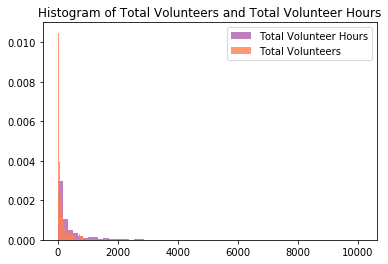

In [31]:
plt.hist(volunt['Total Volunteer Hours'],alpha=.5,bins=60,density=True,label='Total Volunteer Hours',color='purple')
plt.hist(volunt['Total Volunteers'],alpha=.8,bins=60,density=True,label='Total Volunteers',color='coral')
#plt.hist(volunt['Total Events'],alpha=.6,bins=60,density=True,label='Total Events',color='green')
plt.title('Histogram of Total Volunteers and Total Volunteer Hours')
plt.legend()
plt.show();

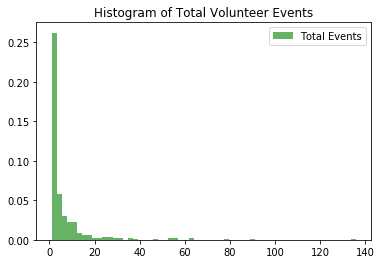

In [32]:
plt.hist(volunt['Total Events'],alpha=.6,bins=60,density=True,label='Total Events',color='green')
plt.title('Histogram of Total Volunteer Events')
plt.legend()
plt.show();

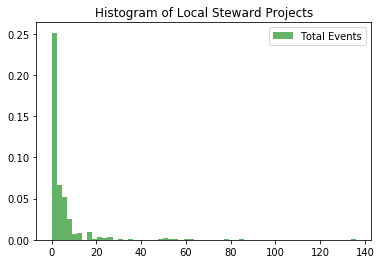

In [33]:
plt.hist(volunt['Local Steward Project'],alpha=.6,bins=60,density=True,label='Total Events',color='green')
plt.title('Histogram of Local Steward Projects')
plt.legend()
plt.show();

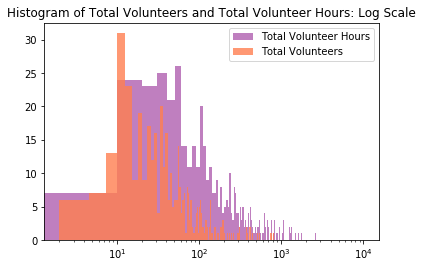

In [34]:
plt.hist(volunt['Total Volunteer Hours'],alpha=.5,bins=1000,label='Total Volunteer Hours',color='purple')
plt.hist(volunt['Total Volunteers'],alpha=.8,bins=1000,label='Total Volunteers',color='coral')
plt.title('Histogram of Total Volunteers and Total Volunteer Hours: Log Scale')
plt.legend()
#plt.yscale('log')
plt.xscale('log')
plt.show();

## What are the outlier parks!??

In [35]:
volunt['Total Volunteers'].head(15)

SIGNNAME
Leif Ericson Park        2648.0
Kaiser Park              2002.0
Astoria Park             1390.0
McCarren Park            1272.0
Sunset Park              1154.0
Morningside Park         1107.0
Westerleigh Park         1043.0
St. Mary's Park           995.0
Eibs Pond Park            829.0
Crotona Park              816.0
Lemon Creek Park          810.0
Thomas Jefferson Park     807.0
Great Kills Park          767.0
MacDonald Park            762.0
Owl's Head Park           761.0
Name: Total Volunteers, dtype: float64

## Joining volunteers to parks and to scores

In [36]:
volunt.index.unique().shape

(495,)

In [37]:
volunt_parks= pd.merge(df_parks[~df_parks.duplicated('SIGNNAME')].drop(['Total Volunteers', 'Total Volunteer Hours','Local Steward Project'],axis=1), volunt[['Total Volunteers','Total Volunteer Hours','Total Events','Local Steward Project']], \
                       on='SIGNNAME',how='inner')[['geometry','COMMUNITYB','GISPROPNUM',\
                                                   'SIGNNAME','ACRES','TYPECATEGO',\
                                                   'BOROUGH','Total Volunteers','Total Volunteer Hours','Total Events','Local Steward Project']]

In [38]:
print('There are ' + str(volunt_parks.shape[0]) + ' parks with active volunteers, which is ' + str( round(volunt_parks.shape[0] * 100/parks['SIGNNAME'].unique().shape[0],1)) + ' percent of all parks.' )

There are 495 parks with active volunteers, which is 32.4 percent of all parks.


In [39]:
volunt_scores= pd.merge(scores, volunt.reset_index(), on='SIGNNAME',how='inner')

In [40]:
volunt_parks['BOROUGH'].value_counts()
#Queens, Manhattan, and Brooklyn dominate (makes sense because more parks there).

Q    124
M    122
B    116
X     65
R     40
Name: BOROUGH, dtype: int64

In [41]:
volunt_scores['SIGNNAME'].unique().shape
#285 parks joined to the scores data

(298,)

In [42]:
volunt_scores['GISPROPNUM'].unique().shape

(300,)

## Correlation between Scores and Volunteers and Volunteer Hours

In [43]:
volunt_scores[['TVPA','TVHPA']]= volunt_scores[['Total Volunteers', 'Total Volunteer Hours']].div(volunt_scores['ACRES'],axis=0)
volunt_scores[['TVPA','TVHPA']];

In [44]:
volunt_scores[['TVPP','TVHPP']]= volunt_scores[['Total Volunteers', 'Total Volunteer Hours']].div(volunt_scores['Pop_nearPark'],axis=0)
volunt_scores[['TVPP','TVHPP']];

In [45]:
volunt_scores[['TVPPDens','TVHPPDens']]= volunt_scores[['Total Volunteers', 'Total Volunteer Hours']].div(volunt_scores['PopDens'],axis=0)
volunt_scores[['TVPPDens','TVHPPDens']];

In [46]:
corr= volunt_scores[score_types+['Total Volunteers', 'Total Volunteer Hours','TVPA','TVHPA','TVPP','TVHPP','TVPPDens','TVHPPDens']].corr()
#Loose correlations between scores and Total Volunteers/Total Volunteer Hours
corr

,tp_palmm,tpa_palmm,tppop_palmm,tppopdens_palmm,Total Volunteers,Total Volunteer Hours,TVPA,TVHPA,TVPP,TVHPP,TVPPDens,TVHPPDens
tp_palmm,1.000000,0.724519,0.888092,0.912391,0.320430,0.267298,0.019602,0.007496,0.109991,0.097861,0.199687,0.165725
tpa_palmm,0.724519,1.000000,0.551364,0.534016,0.394606,0.339481,-0.204564,-0.208310,0.154283,0.145174,0.247496,0.215153
tppop_palmm,0.888092,0.551364,1.000000,0.967619,0.259746,0.224405,0.053043,0.038049,0.291362,0.252951,0.294049,0.247998
tppopdens_palmm,0.912391,0.534016,0.967619,1.000000,0.259394,0.220793,0.093894,0.076613,0.201197,0.177815,0.288868,0.243908
Total Volunteers,0.320430,0.394606,0.259746,0.259394,1.000000,0.956624,0.203579,0.210944,0.608213,0.638693,0.746660,0.722988
Total Volunteer Hours,0.267298,0.339481,0.224405,0.220793,0.956624,1.000000,0.180882,0.214361,0.632858,0.717305,0.748953,0.782745
TVPA,0.019602,-0.204564,0.053043,0.093894,0.203579,0.180882,1.000000,0.970615,0.076018,0.078683,0.101307,0.099399
TVHPA,0.007496,-0.208310,0.038049,0.076613,0.210944,0.214361,0.970615,1.000000,0.095284,0.115886,0.127182,0.142838
TVPP,0.109991,0.154283,0.291362,0.201197,0.608213,0.632858,0.076018,0.095284,1.000000,0.968027,0.831392,0.810568
TVHPP,0.097861,0.145174,0.252951,0.177815,0.638693,0.717305,0.078683,0.115886,0.968027,1.000000,0.846509,0.871687


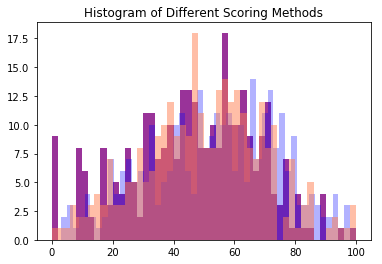

In [47]:
plt.hist(volunt_scores['tp_palmm'], alpha=.8, bins=50, color='purple')
plt.hist(volunt_scores['tpa_palmm'], alpha=.3, bins=50, color='blue')
plt.hist(volunt_scores['tppop_palmm'], alpha=.5, bins=50, color='coral')
plt.title('Histogram of Different Scoring Methods');

## Timeseries

In [48]:
df_all['Date']= pd.to_datetime(df_all['Date'],format="%d/%m/%Y")

In [49]:
df_all= df_all.sort_values('Date')

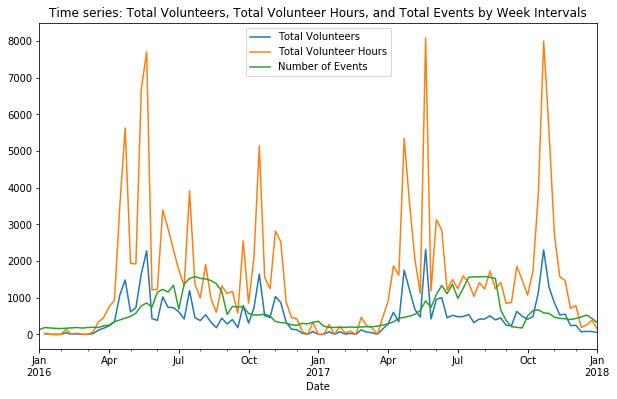

In [50]:
fig, ax= plt.subplots(1,figsize=(10,6))
df_all.resample('W-Mon',on='Date').agg({'Total Volunteers':'sum'}).plot(ax=ax)
df_all.resample('W-Mon',on='Date').agg({'Total Volunteer Hours':'sum'}).plot(ax=ax)
perms[(perms['year']>=2016)&(perms['year']<2018)].resample('W-Mon',on='start_date_time').agg({'event_name':'count'}).rename(columns={'event_name':'Number of Events'}).plot(ax=ax)
plt.xlabel('Date')
plt.title('Time series: Total Volunteers, Total Volunteer Hours, and Total Events by Week Intervals')
plt.show();

## Mapping

In [51]:
type(parks)

geopandas.geodataframe.GeoDataFrame

In [52]:
type(volunt_parks)

geopandas.geodataframe.GeoDataFrame

In [53]:
volunt_parks['Total Volunteers'].max()

2648.0

In [54]:
volunt_parks['Total Volunteers'].min()

2.0

In [55]:
volunt_parks['Total Volunteer Hours'].max()

10148.5

In [56]:
volunt_parks['Total Volunteer Hours'].min()

0.0

In [57]:
#community boards
cds= gpd.read_file(r"S:\NYC_GIS_DATA\community districts\nycd.shp")

In [58]:
voluntcds= gpd.sjoin(volunt_parks, cds, op='intersects',how='left').drop('index_right',axis=1)

In [59]:
voluntcds= pd.merge(cds[['BoroCD','geometry']],voluntcds.groupby('BoroCD').agg({'Total Volunteers':'sum','Total Volunteer Hours':'sum','BOROUGH':'first'}).reset_index(),on='BoroCD',how='left').dropna()

In [60]:
voluntcds.loc[voluntcds['BOROUGH']=='B','BOROUGH']= 'Brooklyn'
voluntcds.loc[voluntcds['BOROUGH']=='X','BOROUGH']= 'the Bronx'
voluntcds.loc[voluntcds['BOROUGH']=='Q','BOROUGH']= 'Queens'
voluntcds.loc[voluntcds['BOROUGH']=='R','BOROUGH']= 'Staten Island'
voluntcds.loc[voluntcds['BOROUGH']=='M','BOROUGH']= 'Manhattan'
voluntcds.loc[voluntcds['BOROUGH']==0,'BOROUGH']= 'Queens'

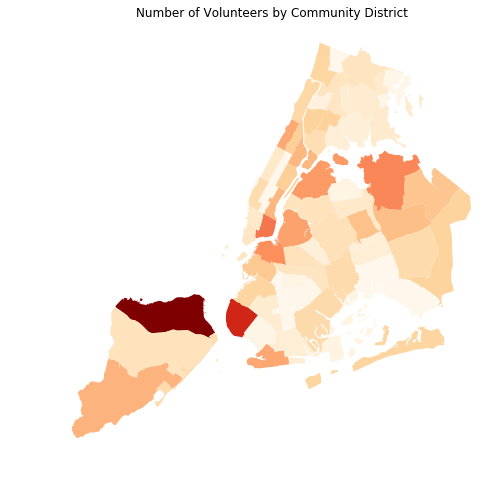

In [61]:
voluntcds.plot(column='Total Volunteers',cmap='OrRd',figsize=(8,8))
plt.axis('off')
plt.title('Number of Volunteers by Community District');

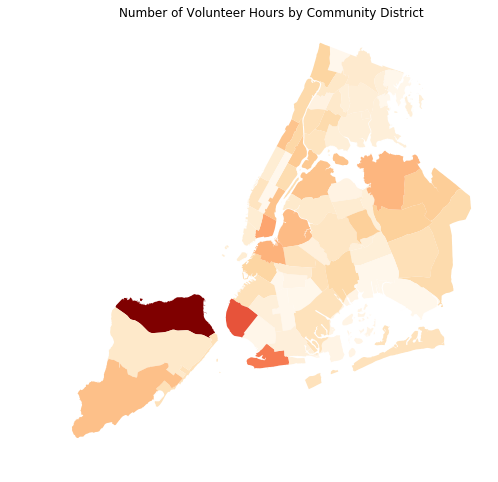

In [62]:
voluntcds.plot(column='Total Volunteer Hours',cmap='OrRd',figsize=(8,8))
plt.axis('off')
plt.title('Number of Volunteer Hours by Community District');

In [63]:
print('The Community District with the most volunteers is: CB ' + \
      str(voluntcds.loc[voluntcds['Total Volunteers'].idxmax(),'BoroCD']) \
      + ' in ' + str(voluntcds.loc[voluntcds['Total Volunteers'].idxmax(),'BOROUGH']) \
      + ' with ' + str(voluntcds['Total Volunteers'].max()) + ' volunteers and '\
      + str(voluntcds.loc[voluntcds['Total Volunteers'].idxmax(),'Total Volunteer Hours'])+ ' volunteer hours.')
print('The Community District with the least volunteers is: CB ' + \
      str(voluntcds.loc[voluntcds['Total Volunteers'].idxmin(),'BoroCD'])\
      + ' in '+ str(voluntcds.loc[voluntcds['Total Volunteers'].idxmin(),'BOROUGH'])\
      + ' with ' + str(voluntcds['Total Volunteers'].min()) + ' volunteers and '\
     + str(voluntcds.loc[voluntcds['Total Volunteers'].idxmin(),'Total Volunteer Hours'])+ ' volunteer hours.')

The Community District with the most volunteers is: CB 501 in Staten Island with 5462.0 volunteers and 20486.5 volunteer hours.
The Community District with the least volunteers is: CB 355 in Brooklyn with 29.0 volunteers and 87.0 volunteer hours.


In [64]:
cds.shape[0]-voluntcds.shape[0]
#Two community districts do not have any volunteers.

2

In [65]:
cds[~cds['BoroCD'].isin(voluntcds['BoroCD'])]
#The Community Districts that don't have any volunteers.

,BoroCD,Shape_Leng,Shape_Area,PUMA,geometry
1,480,45440.919364,3.272360e+07,NaN,"POLYGON ((1022267.307983398 218659.5328369141,..."
44,484,247843.940437,1.237924e+08,NaN,(POLYGON ((1003207.579589844 142541.7250366211...


## Focus on Study Areas: LIC, Bay St., and Bushwick
* what is volunteering like in these neighborhoods?

In [66]:
#Park entrances for study areas
bayst= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_BayStreetCorridorAccessPoints.shp")
bushwick= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_BushwickAccessPoints.shp")
lic1= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_LIC_Parks1acreorlessAccessPoints.shp")
lic2= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_LIC_Parks20acresorgreater.shp")
lic3= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_LIC_Parksbtwn1and20acresAccessPoints.shp")
lic= pd.concat([lic1,lic2,lic3],axis=0)

C:\Users\Jennah\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [67]:
volunt_parks.columns

Index(['geometry', 'COMMUNITYB', 'GISPROPNUM', 'SIGNNAME', 'ACRES',
       'TYPECATEGO', 'BOROUGH', 'Total Volunteers', 'Total Volunteer Hours',
       'Total Events', 'Local Steward Project'],
      dtype='object')

In [68]:
bayst.columns

Index(['gispropnum', 'parkname', 'type', 'geometry'], dtype='object')

In [69]:
volunt_bayst= volunt_parks[volunt_parks['GISPROPNUM'].isin(bayst['gispropnum'])]
volunt_bushwick= volunt_parks[volunt_parks['GISPROPNUM'].isin(bushwick['gispropnum'])]
volunt_lic= volunt_parks[volunt_parks['GISPROPNUM'].isin(lic['gispropnum'])]

In [70]:
scores_bayst= volunt_scores[volunt_scores['GISPROPNUM'].isin(bayst['gispropnum'])]
scores_bushwick= volunt_scores[volunt_scores['GISPROPNUM'].isin(bushwick['gispropnum'])]
scores_lic= volunt_scores[volunt_scores['GISPROPNUM'].isin(lic['gispropnum'])]

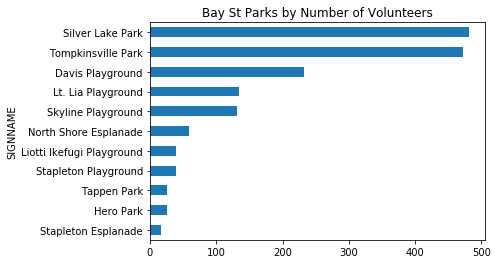

In [71]:
volunt_bayst.set_index('SIGNNAME')['Total Volunteers'].sort_values().plot.barh()
plt.title('Bay St Parks by Number of Volunteers');

In [72]:
scores_bayst.set_index('SIGNNAME')[score_types+['Total Volunteers']].sort_values('Total Volunteers',ascending=False)

,tp_palmm,tpa_palmm,tppop_palmm,tppopdens_palmm,Total Volunteers
SIGNNAME,,,,,
Silver Lake Park,55.0,62.0,55.0,66.0,481.0
Tompkinsville Park,53.0,39.0,69.0,81.0,472.0
Davis Playground,11.0,6.0,30.0,37.0,232.0
Skyline Playground,29.0,48.0,35.0,41.0,132.0
Stapleton Playground,39.0,50.0,42.0,48.0,40.0
Tappen Park,57.0,76.0,59.0,66.0,25.0
Stapleton Esplanade,0.0,12.0,8.0,18.0,16.0


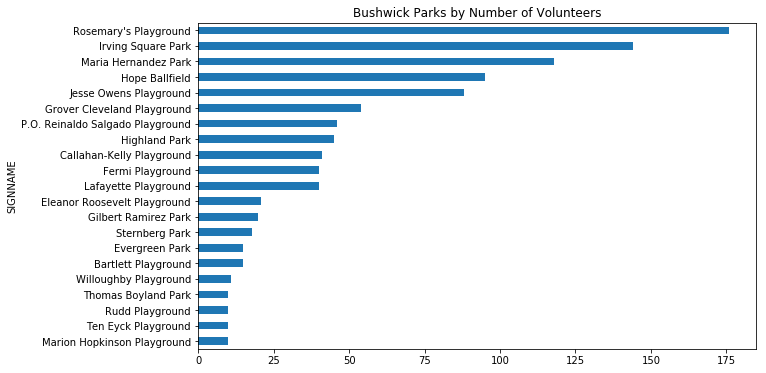

In [73]:
volunt_bushwick.set_index('SIGNNAME')['Total Volunteers'].sort_values().plot.barh(figsize=(10,6))
plt.title('Bushwick Parks by Number of Volunteers');

In [74]:
scores_bushwick.set_index('SIGNNAME')[score_types+['Total Volunteers']].sort_values('Total Volunteers',ascending=False)

,tp_palmm,tpa_palmm,tppop_palmm,tppopdens_palmm,Total Volunteers
SIGNNAME,,,,,
Rosemary's Playground,47.0,66.0,40.0,43.0,176.0
Irving Square Park,56.0,70.0,51.0,51.0,144.0
Maria Hernandez Park,70.0,73.0,60.0,64.0,118.0
Jesse Owens Playground,38.0,55.0,37.0,38.0,88.0
Grover Cleveland Playground,64.0,71.0,61.0,63.0,54.0
Highland Park,63.0,78.0,97.0,73.0,45.0
Callahan-Kelly Playground,34.0,48.0,37.0,40.0,41.0
Lafayette Playground,39.0,29.0,49.0,52.0,40.0
Gilbert Ramirez Park,21.0,48.0,28.0,28.0,20.0


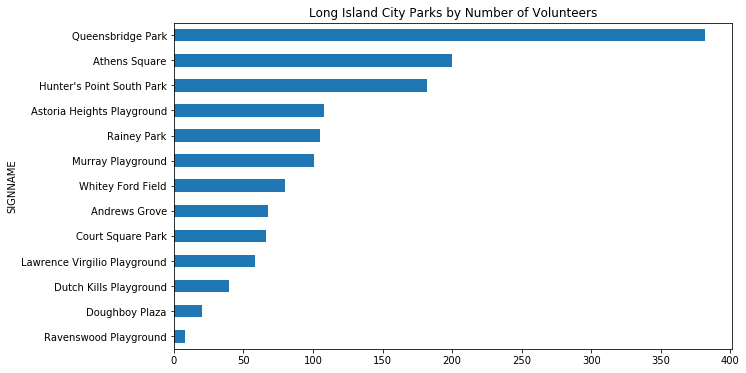

In [75]:
volunt_lic.set_index('SIGNNAME')['Total Volunteers'].sort_values().plot.barh(figsize=(10,6))
plt.title('Long Island City Parks by Number of Volunteers');

In [76]:
scores_lic.set_index('SIGNNAME')[score_types+['Total Volunteers']].sort_values('Total Volunteers',ascending=False)

,tp_palmm,tpa_palmm,tppop_palmm,tppopdens_palmm,Total Volunteers
SIGNNAME,,,,,
Queensbridge Park,57.0,88.0,73.0,59.0,382.0
Athens Square,76.0,45.0,79.0,85.0,200.0
Hunter's Point South Park,52.0,81.0,71.0,57.0,182.0
Astoria Heights Playground,52.0,70.0,48.0,51.0,108.0
Rainey Park,56.0,59.0,68.0,61.0,105.0
Murray Playground,52.0,68.0,61.0,62.0,101.0
Whitey Ford Field,31.0,44.0,46.0,34.0,80.0
Andrews Grove,33.0,25.0,59.0,59.0,68.0
Court Square Park,49.0,35.0,83.0,82.0,66.0


# Zipcodes for Trainings
* Looks at the number and variety of zipcodes at training events
* Looks at the number of zipcodes overall, and where the attendees of trainings might be coming from

In [77]:
zipcodes['Zip Code']= zipcodes['Zip Code'].astype('str')

In [78]:
eventzip= zipcodes.groupby(['Date','Event Name','Borough of Training'])['Zip Code'].value_counts().unstack().reset_index()
#Count of the different zipcodes attending PfP training events

In [79]:
eventzip['Different Zipcodes']= eventzip.loc[:,'10001':'11207-6506'].count(axis=1)

In [80]:
workshops.columns

Index(['Date', 'Class/ Session Name', 'Borough of Training', '# Attended'], dtype='object')

In [81]:
workshops= workshops.rename(columns={'Class/ Session Name': 'Event Name'})

In [82]:
eventzip= pd.merge(eventzip, workshops[['Event Name','# Attended']], on='Event Name',how='inner')

In [83]:
eventzip= eventzip[['Date','Event Name','Borough of Training','Different Zipcodes', '# Attended']].sort_values('# Attended',ascending=False)

In [84]:
eventzip['Borough of Training'].value_counts()
#Most trainings are in Manhattan

Manhattan        19
Brooklyn          2
Bronx             2
Staten Island     2
Queens            1
Name: Borough of Training, dtype: int64

In [85]:
(eventzip.groupby('Borough of Training')['# Attended'].sum() * 100).div(eventzip['# Attended'].sum()).sort_values(ascending=False)
#Even though Staten Island and Brooklyn have the 2nd highest number of trainings, their trainings have a lower share of the # of attendees

Borough of Training
Manhattan        72.504708
Bronx             8.097928
Staten Island     7.909605
Brooklyn          6.779661
Queens            4.708098
Name: # Attended, dtype: float64

In [86]:
eventzip['Date']= pd.to_datetime(eventzip['Date'], format="%d/%m/%Y")

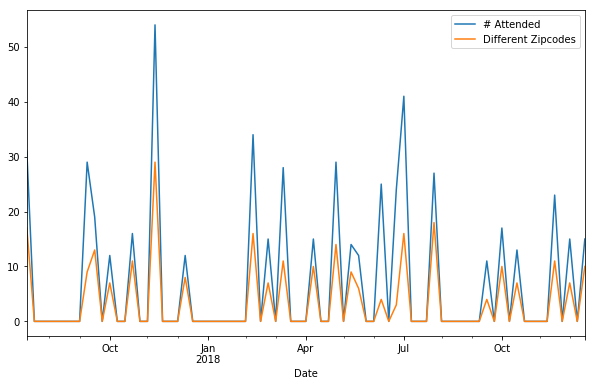

In [87]:
fig, ax= plt.subplots(1,figsize=(10,6))
eventzip.resample('W-Mon',on='Date').agg({'# Attended':'sum'}).plot(ax=ax);
eventzip.resample('W-Mon',on='Date').agg({'Different Zipcodes':'sum'}).plot(ax=ax);

##  Neighborhood Comparison of Zipcodes
* Analysis of trainings to determine zipcodes with the highest number of attendees

In [88]:
zipcount= zipcodes['Zip Code'].value_counts().rename('Count of Zipcodes').reset_index().rename(columns={'index':'ZIPCODE'})

In [89]:
zipcount.shape

(183, 2)

In [90]:
zipcount= zipcount[(zipcount['ZIPCODE'].notna())&((zipcount['ZIPCODE']!='nan'))]

In [91]:
zipcount.loc[zipcount['ZIPCODE'].str.len() > 5,'ZIPCODE']= zipcount.loc[zipcount['ZIPCODE'].str.len() > 5]['ZIPCODE'].str.slice(0,5)

In [92]:
zipcount= zipcount.groupby('ZIPCODE').agg({'Count of Zipcodes':'sum'}).reset_index()

In [93]:
zipcount.shape

(173, 2)

In [94]:
zipshape= gpd.read_file(r"S:\NYC_GIS_DATA\Zip Codes\ZIP_CODE_040114.shp")

In [95]:
zipshape['ZIPCODE'].unique().shape

(248,)

In [96]:
zipshape= pd.merge(zipshape.copy(),zipcount,on='ZIPCODE',how='right').fillna(0)

In [97]:
zipshape.loc[zipshape['CTY_FIPS']=='047', 'BOROUGH']= 'Brooklyn'
zipshape.loc[zipshape['CTY_FIPS']=='081', 'BOROUGH']= 'Queens'
zipshape.loc[zipshape['CTY_FIPS']=='061', 'BOROUGH']= 'Manahttan'
zipshape.loc[zipshape['CTY_FIPS']=='005', 'BOROUGH']= 'Bronx'
zipshape.loc[zipshape['CTY_FIPS']=='085', 'BOROUGH']= 'Staten Island'

In [98]:
zipshape.sort_values('Count of Zipcodes',ascending=False)\
.groupby('BOROUGH')['Count of Zipcodes'].sum().sort_values(ascending=False)

BOROUGH
Manahttan        278
Brooklyn         212
Queens           175
Bronx            150
Staten Island     96
Name: Count of Zipcodes, dtype: int64

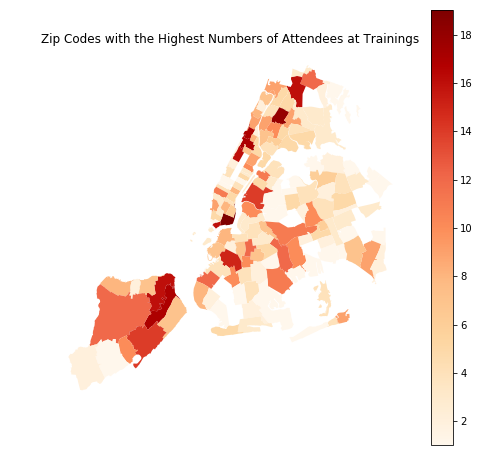

In [99]:
zipshape.plot(column='Count of Zipcodes',cmap='OrRd',legend=True,figsize=(8,8))
plt.axis('off')
plt.title('Zip Codes with the Highest Numbers of Attendees at Trainings');

## Any correlation with median household income?

In [100]:
medinc= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Census\zipcodes_medinc.csv",dtype={'Id2':'str'})

In [101]:
medinc['Id2']= medinc['Id2'].str.zfill(5).str.replace('-','00000')
medinc= medinc.rename(columns={'Id2':'ZIPCODE'})

In [102]:
medinc['medinc']= medinc['medinc'].str.replace('[-+*,]','')
medinc['medinc']= pd.to_numeric(medinc['medinc'])

In [103]:
zipinc= pd.merge(zipshape,medinc,on='ZIPCODE',how='inner').fillna(0)

In [104]:
zipinc.shape

(171, 22)

In [105]:
zipinc[['medinc','Count of Zipcodes']].corr()

,medinc,Count of Zipcodes
medinc,1.000000,-0.209068
Count of Zipcodes,-0.209068,1.000000


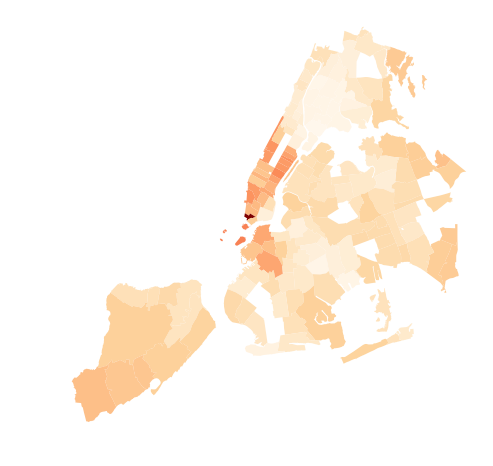

In [106]:
zipinc.plot(column='medinc',cmap='OrRd',figsize=(8,8))
plt.axis('off');

# Analysis of Park Improvement Outcomes
* how have parks improved over time?
* eventoutcomes= outcomes for each specific event, organized by park
* parkoutcomes= outcomes for each park, organized by year and by park
* Most improvements seem to be plants, debris removed, and woodchips/mulch spread.

In [107]:
eventoutcomes= outcomes.groupby(['SIGNNAME','First Shift','Item']).agg({'Item Amount':'sum'}).unstack().reset_index()

In [108]:
eventoutcomes['First Shift']= pd.to_datetime(eventoutcomes['First Shift'])

In [109]:
eventoutcomes['Year']= eventoutcomes['First Shift'].dt.year

In [110]:
parkoutcomes= eventoutcomes.set_index(['SIGNNAME','Year'])['Item Amount']

In [111]:
items= parkoutcomes.columns.tolist()

In [112]:
parkoutcomes=parkoutcomes.reset_index().groupby('SIGNNAME').agg(dict(zip(items, ['sum' for x in items]))).reset_index()

In [113]:
parkoutcomes['SIGNNAME'].unique().shape

(549,)

In [114]:
parkoutcomes['NSum']= parkoutcomes.loc[:,items].sum(axis=1)

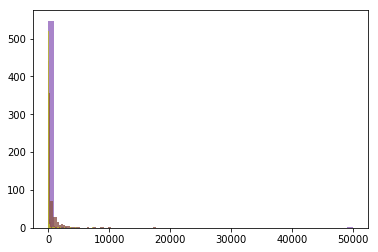

In [115]:
for i in items:
    plt.hist(parkoutcomes[i], alpha=.8, bins=50)

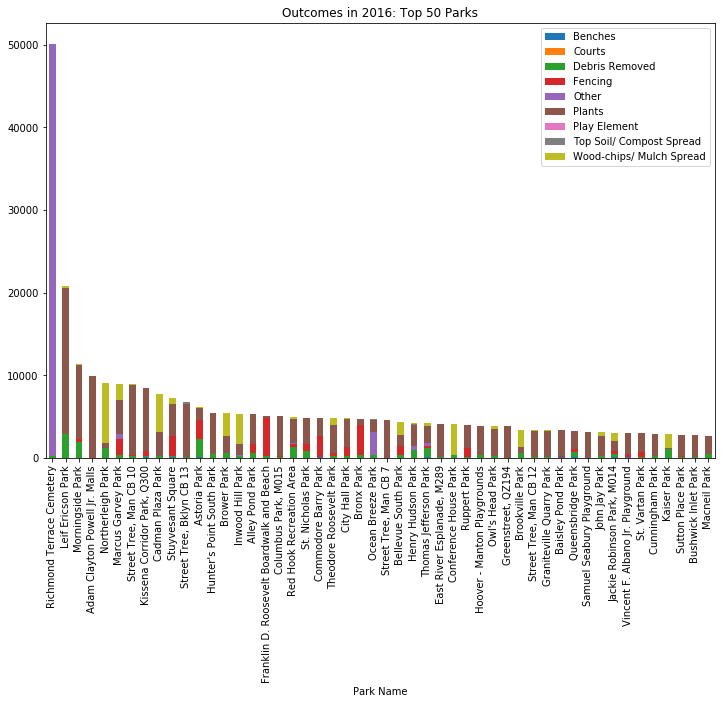

In [116]:
parkoutcomes.set_index('SIGNNAME').sort_values('NSum',ascending=False)\
.drop('NSum',axis=1).loc[:,items].head(50).plot.bar(stacked=True, figsize=(12,8))
plt.title('Outcomes in 2016: Top 50 Parks')
plt.xlabel('Park Name');
#Not really sure how you can measure or compare because items have different measurements.
#Score parks based on improvements?

In [117]:
parkoutcomes['DiffOutcomes']= parkoutcomes.loc[:,'Benches':'Wood-chips/ Mulch Spread'].apply(lambda x: sum(x>0), axis=1)
parkoutcomes;

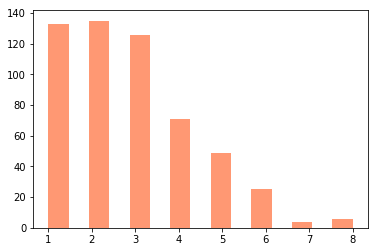

In [118]:
plt.hist(parkoutcomes['DiffOutcomes'], alpha=.8, bins=15, color='coral');

In [119]:
#What about grouping not at the park level but at the community district level??

# Scoring Total Volunteers and Total Volunteers Hours
* tv_mm: total volunteers with min-max normalization
* tv_lmm: total volunteers with log min-max normalization
* tv_palmm: total volunteers with log min-max normalization adjusted for park type

## Log Min-Max Normalization

In [120]:
volunt_parks.columns

Index(['geometry', 'COMMUNITYB', 'GISPROPNUM', 'SIGNNAME', 'ACRES',
       'TYPECATEGO', 'BOROUGH', 'Total Volunteers', 'Total Volunteer Hours',
       'Total Events', 'Local Steward Project'],
      dtype='object')

In [121]:
park_types= ['PP','NP','LP']

In [122]:
volunt_parks.shape

(495, 11)

In [123]:
volunt_toscore= volunt_parks[['SIGNNAME','GISPROPNUM','ACRES','TYPECATEGO','Total Volunteers','Total Volunteer Hours','Total Events','Local Steward Project']].set_index('GISPROPNUM')

In [124]:
tmax= volunt_toscore['Total Volunteers'].max()
tmin= volunt_toscore['Total Volunteers'].min()

In [125]:
volunt_toscore['tv_mm']= (volunt_toscore['Total Volunteers'].apply(lambda x: (x-tmin)/(tmax-tmin))*100).round(0)
volunt_toscore['tv_lmm']= (volunt_toscore['Total Volunteers'].apply(lambda x: (np.log(x)-np.log(tmin))/(np.log(tmax)-np.log(tmin)))*100).round(0)

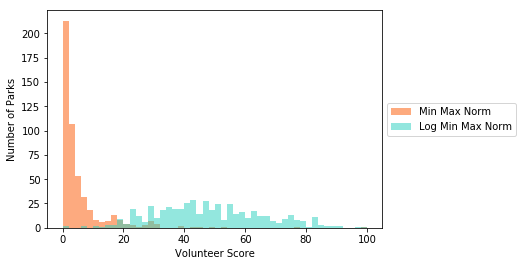

In [126]:
a= volunt_toscore['tv_mm'].values
b= volunt_toscore['tv_lmm'].values

bins= np.arange(0, 102, 2)

#plt.hist(aa, bins, alpha=0.5, label='All', color='#dfdfdf')
plt.hist(a, bins, alpha=0.5, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')
#plt.hist(a, bins, alpha=0.5, label='Not Reported', color='#9355B0')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Volunteer Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Events_MM_LMM.pdf'))

plt.show();

In [127]:
volunt_toscore= volunt_toscore.rename(columns={'Total Volunteers':'tv', 'Total Volunteer Hours':'tvh'})
volunt_toscore.head()
#renames total volunteers as tv and total volunteer hours as tvh

,SIGNNAME,ACRES,TYPECATEGO,tv,tvh,Total Events,Local Steward Project,tv_mm,tv_lmm
GISPROPNUM,,,,,,,,,
Q104,Queensbridge Park,20.340,Community Park,382.0,954.0,12,3.0,14.0,73.0
B379,Coney Island Creek Park,8.892,Nature Area,12.0,36.0,1,0.0,0.0,25.0
B385,WNYC Transmitter Park,6.611,Neighborhood Park,31.0,93.0,2,2.0,1.0,38.0
B129,Kaiser Park,26.257,Community Park,2002.0,10148.5,14,8.0,76.0,96.0
B126,Red Hook Recreation Area,58.503,Community Park,735.0,2231.0,39,34.0,28.0,82.0


## Normalization Park Type Adjusted
* Uses NY4P Categories

In [128]:
volunt_toscore.loc[volunt_toscore['ACRES']<1, 'TYPECATEGO']= 'PP'
volunt_toscore.loc[volunt_toscore['ACRES']>20, 'TYPECATEGO']= 'LP'
volunt_toscore.loc[(volunt_toscore['ACRES']>=1)&(volunt_toscore['ACRES']<=20), 'TYPECATEGO']= 'NP'

In [129]:
park_types= ['PP','NP','LP']

In [130]:
fordf= []

for p in park_types:
    v= volunt_toscore[volunt_toscore['TYPECATEGO']==p]['tv'].values
    fordf.append([p, v.max(), v.min()])

In [131]:
minmaxes= pd.DataFrame(np.array(fordf), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

for n, s in minmaxes.iteritems():
    minmaxes[n]= s.astype(np.float32)
    
minmaxes['DELTA']= minmaxes['MAX']-minmaxes['MIN']

In [132]:
minmaxes

,MAX,MIN,DELTA
TYPECATEGO,,,
PP,572.0,3.0,569.0
NP,2648.0,6.0,2642.0
LP,2002.0,2.0,2000.0


In [133]:
def park_type_adjusted(x, pt, lookup):
    try:
        mi= np.log(lookup.loc[pt, 'MIN'])
        mx= np.log(lookup.loc[pt, 'MAX'])
        dt= mx-mi
        return round((np.log(x)-mi)/dt*100, 0)
    except KeyError:
        return np.nan

In [134]:
volunt_toscore['tv_palmm']= [park_type_adjusted(x, pt, minmaxes) for x, pt in volunt_toscore[['tv', 'TYPECATEGO']].itertuples(index=False)]

In [135]:
three_colors= ['#FD5700', '#29D0BF', '#9355B0']

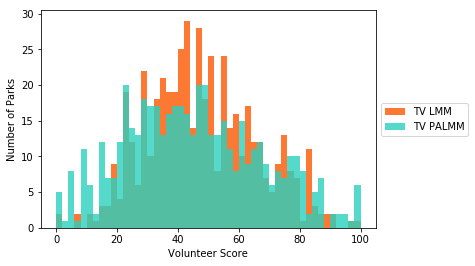

In [136]:
bins= np.arange(0, 102, 2)

tv_lmm= volunt_toscore['tv_lmm'].values
tv_palmm= volunt_toscore['tv_palmm'].values

plt.hist(tv_lmm, bins,label='TV LMM', color=three_colors[0], alpha=.8)
plt.hist(tv_palmm, bins, label='TV PALMM', color=three_colors[1], alpha=.8)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Volunteer Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Permits LMM and Total Permits Adjusted LMM.pdf'))

plt.show();

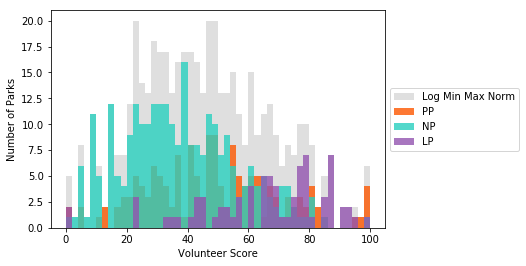

In [137]:
bins= np.arange(0, 102, 2)

plt.hist(volunt_toscore['tv_palmm'].values, bins, label='Log Min Max Norm', color='#dfdfdf')

for pt, c in zip(park_types, three_colors):
    scores= volunt_toscore[volunt_toscore['TYPECATEGO']==pt]['tv_palmm'].values
    plt.hist(scores, bins,label=pt, alpha=.8,color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Volunteer Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Permits Adjusted LMM by Park Type.pdf'))

plt.show();

# Scoring Total Volunteer Events
* tve_mm: total volunteer events with min-max normalization
* tve_lmm: total volunteer events with log min-max normalization
* tve_palmm: total volunteer events with log min-max normalization adjusted for park type

## Log Min-Max Normalization

In [138]:
volunt_parks.columns

Index(['geometry', 'COMMUNITYB', 'GISPROPNUM', 'SIGNNAME', 'ACRES',
       'TYPECATEGO', 'BOROUGH', 'Total Volunteers', 'Total Volunteer Hours',
       'Total Events', 'Local Steward Project'],
      dtype='object')

In [139]:
volunt_parks.shape

(495, 11)

In [140]:
tmax= volunt_toscore['Total Events'].max()
tmin= volunt_toscore['Total Events'].min()

In [141]:
volunt_toscore['tve_mm']= (volunt_toscore['Total Events'].apply(lambda x: (x-tmin)/(tmax-tmin))*100).round(0)
volunt_toscore['tve_lmm']= (volunt_toscore['Total Events'].apply(lambda x: (np.log(x)-np.log(tmin))/(np.log(tmax)-np.log(tmin)))*100).round(0)

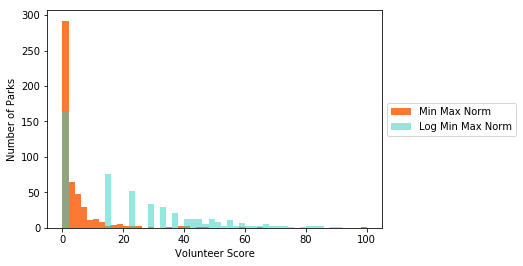

In [142]:
a= volunt_toscore['tve_mm'].values
b= volunt_toscore['tve_lmm'].values

bins= np.arange(0, 102, 2)

#plt.hist(aa, bins, alpha=0.5, label='All', color='#dfdfdf')
plt.hist(a, bins, alpha=0.8, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')
#plt.hist(a, bins, alpha=0.5, label='Not Reported', color='#9355B0')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Volunteer Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Events_MM_LMM.pdf'))

plt.show();

In [143]:
volunt_toscore= volunt_toscore.rename(columns={'Total Events':'tve'})
volunt_toscore.head()
#renames total volunteers as tv and total volunteer hours as tvh

,SIGNNAME,ACRES,TYPECATEGO,tv,tvh,tve,Local Steward Project,tv_mm,tv_lmm,tv_palmm,tve_mm,tve_lmm
GISPROPNUM,,,,,,,,,,,,
Q104,Queensbridge Park,20.340,LP,382.0,954.0,12,3.0,14.0,73.0,76.0,8.0,51.0
B379,Coney Island Creek Park,8.892,NP,12.0,36.0,1,0.0,0.0,25.0,11.0,0.0,0.0
B385,WNYC Transmitter Park,6.611,NP,31.0,93.0,2,2.0,1.0,38.0,27.0,1.0,14.0
B129,Kaiser Park,26.257,LP,2002.0,10148.5,14,8.0,76.0,96.0,100.0,10.0,54.0
B126,Red Hook Recreation Area,58.503,LP,735.0,2231.0,39,34.0,28.0,82.0,85.0,28.0,75.0


## Normalization Park Type Adjusted
* Uses NY4P Categories

In [144]:
fordf= []

for p in park_types:
    v= volunt_toscore[volunt_toscore['TYPECATEGO']==p]['tve'].values
    fordf.append([p, v.max(), v.min()])

In [145]:
minmaxes= pd.DataFrame(np.array(fordf), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

for n, s in minmaxes.iteritems():
    minmaxes[n]= s.astype(np.float32)
    
minmaxes['DELTA']= minmaxes['MAX']-minmaxes['MIN']

In [146]:
minmaxes

,MAX,MIN,DELTA
TYPECATEGO,,,
PP,55.0,1.0,54.0
NP,89.0,1.0,88.0
LP,136.0,1.0,135.0


In [147]:
volunt_toscore['tve_palmm']= [park_type_adjusted(x, pt, minmaxes) for x, pt in volunt_toscore[['tve', 'TYPECATEGO']].itertuples(index=False)]

In [148]:
three_colors= ['#FD5700', '#29D0BF', '#9355B0']

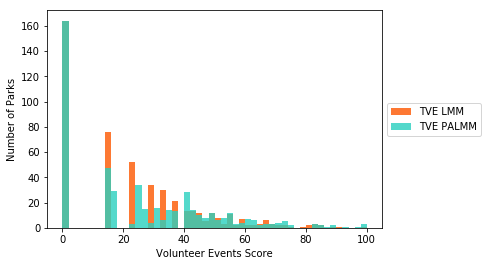

In [149]:
bins= np.arange(0, 102, 2)

tve_lmm= volunt_toscore['tve_lmm'].values
tve_palmm= volunt_toscore['tve_palmm'].values

plt.hist(tve_lmm, bins,label='TVE LMM', color=three_colors[0], alpha=.8)
plt.hist(tve_palmm, bins, label='TVE PALMM', color=three_colors[1], alpha=.8)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Volunteer Events Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Permits LMM and Total Permits Adjusted LMM.pdf'))

plt.show();

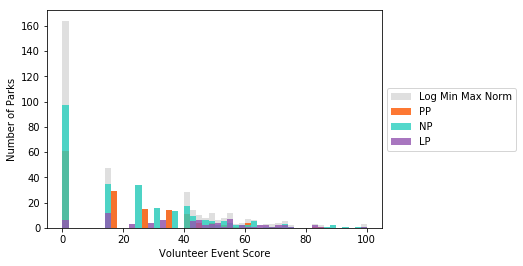

In [150]:
bins= np.arange(0, 102, 2)

plt.hist(volunt_toscore['tve_palmm'].values, bins, label='Log Min Max Norm', color='#dfdfdf')

for pt, c in zip(park_types, three_colors):
    scores= volunt_toscore[volunt_toscore['TYPECATEGO']==pt]['tve_palmm'].values
    plt.hist(scores, bins,label=pt, alpha=.8,color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Volunteer Event Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Permits Adjusted LMM by Park Type.pdf'))

plt.show();

In [151]:
indicators= ['tp','tpa','tppop','tppopdens']

In [152]:
volunt_toscore.index.unique().shape
#495 parks scored by volunteers

(495,)

In [153]:
volunt_scores.shape

(300, 32)

# Scoring Local Steward Projects
* lsp_mm: number of local steward projects with min-max normalization
* lsp_lmm: number of local steward with log min-max normalization
* lsp_palmm: number of local steward projects with log min-max normalization adjusted for park type

## Log Min-Max Normalization

In [154]:
no0= volunt_toscore[volunt_toscore['Local Steward Project']!=0].copy()

In [155]:
tmax= no0['Local Steward Project'].max()
tmin= no0['Local Steward Project'].min()

In [156]:
no0['lsp_mm']= (no0['Local Steward Project'].apply(lambda x: (x-tmin)/(tmax-tmin))*100).round(0)
no0['lsp_lmm']= (no0['Local Steward Project'].apply(lambda x: (np.log(x)-np.log(tmin))/(np.log(tmax)-np.log(tmin)))*100).round(0)

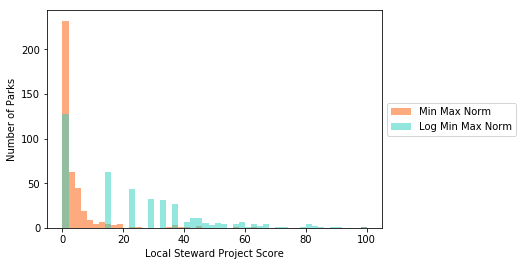

In [157]:
a= no0['lsp_mm'].values
b= no0['lsp_lmm'].values

bins= np.arange(0, 102, 2)

#plt.hist(aa, bins, alpha=0.5, label='All', color='#dfdfdf')
plt.hist(a, bins, alpha=0.5, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')
#plt.hist(a, bins, alpha=0.5, label='Not Reported', color='#9355B0')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Local Steward Project Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Events_MM_LMM.pdf'))

plt.show();

In [158]:
no0= no0.rename(columns={'Local Steward Project':'lsp'})
no0.head();
#renames total volunteers as tv and total volunteer hours as tvh

## Normalization Park Type Adjusted
* Uses NY4P Categories

In [159]:
fordf= []

for p in park_types:
    v= no0[no0['TYPECATEGO']==p]['lsp'].values
    fordf.append([p, v.max(), v.min()])

In [160]:
minmaxes= pd.DataFrame(np.array(fordf), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

for n, s in minmaxes.iteritems():
    minmaxes[n]= s.astype(np.float32)
    
minmaxes['DELTA']= minmaxes['MAX']-minmaxes['MIN']

In [161]:
minmaxes

,MAX,MIN,DELTA
TYPECATEGO,,,
PP,55.0,1.0,54.0
NP,85.0,1.0,84.0
LP,136.0,1.0,135.0


In [162]:
no0['lsp_palmm']= [park_type_adjusted(x, pt, minmaxes) for x, pt in no0[['lsp', 'TYPECATEGO']].itertuples(index=False)]

In [163]:
three_colors= ['#FD5700', '#29D0BF', '#9355B0']

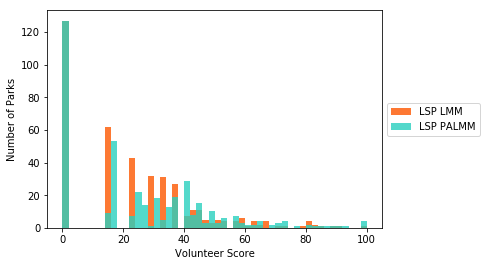

In [164]:
bins= np.arange(0, 102, 2)

lsp_lmm= no0['lsp_lmm'].values
lsp_palmm= no0['lsp_palmm'].values

plt.hist(lsp_lmm, bins,label='LSP LMM', color=three_colors[0], alpha=.8)
plt.hist(lsp_palmm, bins, label='LSP PALMM', color=three_colors[1], alpha=.8)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Volunteer Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Permits LMM and Total Permits Adjusted LMM.pdf'))

plt.show();

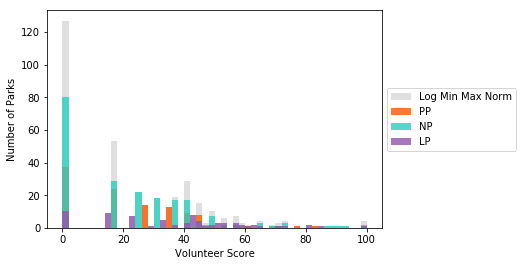

In [165]:
bins= np.arange(0, 102, 2)

plt.hist(no0['lsp_palmm'].values, bins, label='Log Min Max Norm', color='#dfdfdf')

for pt, c in zip(park_types, three_colors):
    scores= no0[no0['TYPECATEGO']==pt]['lsp_palmm'].values
    plt.hist(scores, bins,label=pt, alpha=.8,color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Volunteer Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Permits Adjusted LMM by Park Type.pdf'))

plt.show();

# Scatter and Correlation of Scores
* comparison: only includes relevant columns (original values, i.e. indicators and normalized scores)
* indicators= tp, tpa, tppop, tppopdens (doesn't include tv)
* score_types= tp_palmm, tpa_palmm, tppop_palmm, tppopdens_palmm (doesn't include tv_palmm)

In [166]:
volunt_scores= pd.merge(volunt_scores, scores2, on='GISPROPNUM', how='inner')

In [167]:
comp= pd.merge(volunt_scores[indicators+score_types+['GISPROPNUM']], volunt_toscore, on='GISPROPNUM', how='inner').set_index('GISPROPNUM')
comp_t= comp.copy()

In [168]:
comp.sort_values('tv_palmm', ascending=False)[['SIGNNAME']+score_types+['tv_palmm']].shape

(297, 6)

In [169]:
comp.head()

,tp,tpa,tppop,tppopdens,tp_palmm,tpa_palmm,tppop_palmm,tppopdens_palmm,SIGNNAME,ACRES,...,tv,tvh,tve,Local Steward Project,tv_mm,tv_lmm,tv_palmm,tve_mm,tve_lmm,tve_palmm
GISPROPNUM,,,,,,,,,,,,,,,,,,,,,
Q104,404.0,19.862340,0.065650,9.686882,57.0,88.0,73.0,59.0,Queensbridge Park,20.340,...,382.0,954.0,12,3.0,14.0,73.0,76.0,8.0,51.0,51.0
B129,806.0,30.696576,0.051589,12.168219,63.0,93.0,70.0,62.0,Kaiser Park,26.257,...,2002.0,10148.5,14,8.0,76.0,96.0,100.0,10.0,54.0,54.0
B126,357.0,6.102251,0.028808,9.626909,56.0,75.0,62.0,59.0,Red Hook Recreation Area,58.503,...,735.0,2231.0,39,34.0,28.0,82.0,85.0,28.0,75.0,75.0
R008,56.0,12.906200,0.006426,2.302929,47.0,57.0,54.0,58.0,Faber Pool and Park,4.339,...,23.0,69.0,1,1.0,1.0,34.0,22.0,0.0,0.0,0.0
B169B,24.0,8.152174,0.002791,0.356007,37.0,52.0,46.0,40.0,Poseidon Playground,2.944,...,78.0,336.0,4,4.0,3.0,51.0,42.0,2.0,28.0,31.0


In [170]:
comp[score_types+['tv_palmm']].corr()

,tp_palmm,tpa_palmm,tppop_palmm,tppopdens_palmm,tv_palmm
tp_palmm,1.000000,0.720080,0.887481,0.911498,0.396626
tpa_palmm,0.720080,1.000000,0.546647,0.527456,0.215265
tppop_palmm,0.887481,0.546647,1.000000,0.967511,0.371875
tppopdens_palmm,0.911498,0.527456,0.967511,1.000000,0.387764
tv_palmm,0.396626,0.215265,0.371875,0.387764,1.000000


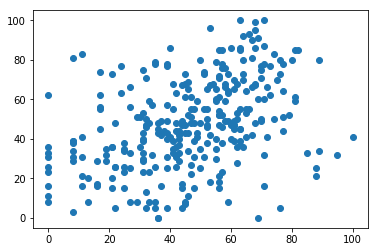

In [171]:
plt.scatter(comp['tp_palmm'].values, comp['tv_palmm'].values);

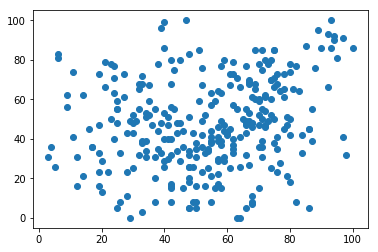

In [172]:
plt.scatter(comp['tpa_palmm'].values, comp['tv_palmm'].values);

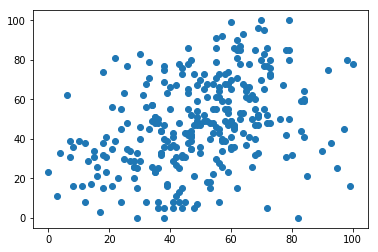

In [173]:
plt.scatter(comp['tppop_palmm'].values, comp['tv_palmm'].values);

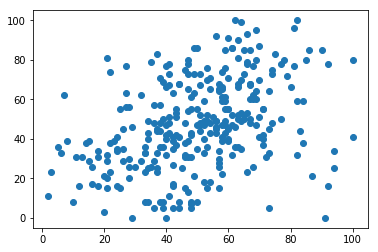

In [174]:
plt.scatter(comp['tppopdens_palmm'].values, comp['tv_palmm'].values);

## Benchmarks
* Option 1 - using tv_palmm and tp_palmm .75 quantiles
    - 11.5 permitted events per year
    - 50 volunteers per year
    - 0.6 permitted events per year per park acre
    - 3 events per year for 10,000 people
    - 0.5 events per year per person per acre
* Option 2 - in one year
    - For Pocket Parks:
        - 11.5 permitted events
        - 15 permitted events per acre
        - 4 events per 10,000 people in 10-minutes walking distance
        - 0.1 events per person per acre
    - For Neighborhood Parks:
        - 24 permitted events
        - 7 permitted events per acre
        - 15 events per 10,000 people in 10-minutes walking distance
        - 0.4 events per person per acre
    - For Large Parks:
        - 208 permitted events
        - 4 permitted events per acre
        - 163 events per 10,000 people
        - 24 events per person per acre

In [175]:
comp['tp'].min()

1.0

In [176]:
comp['tp'].max()

38611.0

In [177]:
comp[(comp['tv_palmm']>=comp['tv_palmm'].quantile(.75))&(comp['tp_palmm']>=comp['tp_palmm'].quantile(.75))]['tp'].min()/6

11.5

In [178]:
comp[(comp['tv_palmm']>=comp['tv_palmm'].quantile(.75))&(comp['tp_palmm']>=comp['tp_palmm'].quantile(.75))]['tv'].min()/2

50.5

In [179]:
comp[(comp['tv_palmm']>=comp['tv_palmm'].quantile(.75))&(comp['tpa_palmm']>=comp['tpa_palmm'].quantile(.75))]['tpa'].min()/6

0.6211445632587563

In [180]:
comp[(comp['tv_palmm']>=comp['tv_palmm'].quantile(.75))&(comp['tppop_palmm']>=comp['tppop_palmm'].quantile(.75))]['tppop'].min()*10000/6

2.9925717482123524

In [181]:
comp[(comp['tv_palmm']>=comp['tv_palmm'].quantile(.75))&(comp['tppopdens_palmm']>=comp['tppopdens_palmm'].quantile(.75))]['tppopdens'].min()/6

0.05755253166038319

In [182]:
comp= comp_t.copy().reset_index()
comp['tp']= comp['tp']/6
comp['tpa']= comp['tpa']/6
comp['tppop']= comp['tppop']*10000/6
#comp['tppop']= 10000/comp['tppop']
#comp['tv']= comp['tv']/2
comp['tppopdens']= comp['tppopdens']/6

In [183]:
comp[score_types[0]];

In [184]:
benchmarks= pd.DataFrame(index= indicators, columns=park_types)
for i in park_types:
    for j in range(4):
        benchmarks.loc[indicators[j], i]= comp[(comp['TYPECATEGO']==i)&(comp['tv_palmm']>=comp[comp['TYPECATEGO']==i]['tv_palmm'].quantile(.75))&(comp[score_types[j]]>=comp[comp['TYPECATEGO']==i][score_types[j]].quantile(.75))][indicators[j]].min(skipna=True)
              

In [185]:
benchmarks

,PP,NP,LP
tp,11.5,23.6667,208.167
tpa,14.878,7.22344,3.80557
tppop,4.1665,14.7594,163.254
tppopdens,0.123175,0.387241,24.2885


# Benchmarks to Neighborhoods

In [186]:
#Park entrances for different neighborhood
bayst= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_BayStreetCorridorAccessPoints.shp")
bushwick= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_BushwickAccessPoints.shp")
lic1= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_LIC_Parks1acreorlessAccessPoints.shp")
lic2= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_LIC_Parks20acresorgreater.shp")
lic3= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park_LIC_Parksbtwn1and20acresAccessPoints.shp")
lic= pd.concat([lic1,lic2,lic3],axis=0)

C:\Users\Jennah\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [187]:
cds= gpd.read_file(r"S:\NYC_GIS_DATA\community districts\nycd.shp")

In [188]:
uws= gpd.sjoin(parks,cds[cds['BoroCD']==107],op='intersects',how='inner')

In [189]:
parkslope= gpd.sjoin(parks,cds[cds['BoroCD']==306],op='intersects',how='inner')

In [190]:
les= gpd.sjoin(parks,cds[cds['BoroCD']==103],op='intersects',how='inner')

## Neighborhoods
* Prints detailed summaries for each study area and comparison neighborhood.
* Offers insights into how many benchmarks each park passes.
* Creates tables for score comparison

In [191]:
# Reloading scores data
scores= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - Scores\190729_TParks by Acre and Pop.csv")
scores2= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - Scores\190729_TParks by Acre and Pop_NoNormalization.csv")
scores= pd.merge(scores,parks[['GISPROPNUM','SIGNNAME']], on='GISPROPNUM', how='inner')
scores2= pd.merge(scores2, scores.drop('TYPECATEGO',axis=1), on='GISPROPNUM', how='inner')

In [192]:
scores2_t= scores2.copy()

In [193]:
scores2= scores2_t.copy().reset_index()
scores2['tp']= scores2['tp']/6
scores2['tpa']= scores2['tpa']/6
scores2['tppop']= scores2['tppop']*10000/6
#scores2['tppop']= 10000/scores2['tppop']
#scores2['tv']= scores2['tv']/2
scores2['tppopdens']= scores2['tppopdens']/6

In [194]:
bayst_scores= scores2[scores2['GISPROPNUM'].isin(bayst['gispropnum'])]
bushwick_scores= scores2[scores2['GISPROPNUM'].isin(bushwick['gispropnum'])]
lic_scores= scores2[scores2['GISPROPNUM'].isin(lic['gispropnum'])]
uws_scores= scores2[scores2['GISPROPNUM'].isin(uws['GISPROPNUM'])]
parkslope_scores= scores2[scores2['GISPROPNUM'].isin(parkslope['GISPROPNUM'])]
les_scores= scores2[scores2['GISPROPNUM'].isin(les['GISPROPNUM'])]

In [195]:
bayst_scores;

In [196]:
def calc_nhoodscores(temp_scores, nhood):
    '''
    Takes in a subsetted dataset of scores (subsetted to the neighborhood).
    Prints the number of parks that pass the benchmarks and returns the GISPROPNUM
    of these high-scoring parks.
    '''
    print('The scores for ' + nhood + ' are:')
    print('')
    nhood_score= [0,0,0,0]
    #temp_scores= bayst_scores.copy()
    park_score= np.array([])
    park_score2= np.array([])
    for i in temp_scores.index:
        categ= temp_scores.loc[i,'TYPECATEGO']
        for j in range(len(indicators)):
            if temp_scores.loc[i,indicators[j]] > benchmarks.loc[indicators[j],categ]:
                nhood_score[j]+= 1
                print(str(temp_scores.loc[i,'SIGNNAME']) + ' is a ' + str(temp_scores.loc[i,'TYPECATEGO'])+ ' and passes benchmark ' + str(indicators[j])+'.')
                park_score= np.unique(np.append(park_score, [temp_scores.loc[i,'GISPROPNUM']]))
                park_score2= np.unique(np.append(park_score2, [temp_scores.loc[i,'SIGNNAME']]))
        
    print('')
    print('There are ' + str(len(park_score)) + ' high-scoring parks. This represents ' + str( round(len(park_score) * 100/temp_scores['SIGNNAME'].unique().shape[0])) + '% of all parks. High-scoring parks are:')
    print('')
    for k in range(len(park_score2)):
        print(park_score2[k])
    return park_score

In [277]:
def nhoodscore_tables(temp_scores):
    '''
    Takes in a subsetted dataset of scores (subsetted to the neighborhood).
    Returns a summary table for the neighborhood.
    '''
    summary= pd.DataFrame(index=temp_scores['GISPROPNUM'], columns=['SIGNNAME','ACRES','TYPECATEGO','High-scoring Park', 'Passes']+indicators+score_types)
    for i in temp_scores.index:
        categ= temp_scores.loc[i,'TYPECATEGO']
        gispropnum= temp_scores.loc[i,'GISPROPNUM']
        signname= temp_scores.loc[i,'SIGNNAME']
        num_pass= 0
        summary.loc[gispropnum,'SIGNNAME']= signname
        summary.loc[gispropnum,'TYPECATEGO']= categ
        summary.loc[gispropnum,'ACRES']= parks.loc[i,'ACRES']
        for j in range(len(indicators)):
            if temp_scores.loc[i,indicators[j]] > benchmarks.loc[indicators[j],categ]:
                num_pass+= 1
        if num_pass >0:
            summary.loc[gispropnum, 'High-scoring Park']= 1
            summary.loc[gispropnum,'Passes']= num_pass
        summary.loc[gispropnum,indicators]= temp_scores.loc[i,indicators]
        summary.loc[gispropnum, score_types]= temp_scores.loc[i,score_types]
        
    return summary

In [278]:
def calc_allscores(cds, parks):
    '''
    Takes in a spatial data file of community districts and of parks.
    Returns the percent of parks that pass benchmarks for every community district in NYC.
    '''
    nhood_score= []
    for k in cds['BoroCD'].unique().tolist():
        temp= gpd.sjoin(parks,cds[cds['BoroCD']==k],op='intersects',how='inner')
        park_score= np.array([])
        temp_scores= scores2[scores2['GISPROPNUM'].isin(temp['GISPROPNUM'])]
        for i in temp_scores.index:
            categ= temp_scores.loc[i,'TYPECATEGO']
            for j in range(len(indicators)):
                if temp_scores.loc[i,indicators[j]] > benchmarks.loc[indicators[j],categ]:
                    park_score= np.unique(np.append(park_score, [temp_scores.loc[i,'SIGNNAME']]))
        if temp_scores['SIGNNAME'].unique().shape[0] > 0:
            nhood_score+= [(str('CD ')+str(k), round(len(park_score) * 100/temp_scores['SIGNNAME'].unique().shape[0]))]
    return nhood_score

In [279]:
nhoodvalues= calc_allscores(cds,parks)

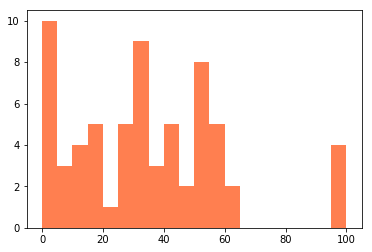

In [280]:
nhoodvalues.sort(key= lambda x: x[1])
plt.hist([x[1] for x in nhoodvalues], bins=20, color='coral');

In [281]:
highperf= calc_nhoodscores(scores2,'Citywide');
#Citywide average is 29% with 174 high-scoring parks.

The scores for Citywide are:

Socrates Sculpture Park is a NP and passes benchmark tp.
Socrates Sculpture Park is a NP and passes benchmark tppop.
Socrates Sculpture Park is a NP and passes benchmark tppopdens.
Kaiser Park is a LP and passes benchmark tpa.
Francis Lewis Park is a NP and passes benchmark tppop.
Francis Lewis Park is a NP and passes benchmark tppopdens.
Astoria Park is a LP and passes benchmark tp.
Sherman Creek is a NP and passes benchmark tp.
Sherman Creek is a NP and passes benchmark tppop.
Sherman Creek is a NP and passes benchmark tppopdens.
Jaime Campiz Playground is a PP and passes benchmark tp.
Jaime Campiz Playground is a PP and passes benchmark tpa.
Jaime Campiz Playground is a PP and passes benchmark tppop.
Jaime Campiz Playground is a PP and passes benchmark tppopdens.
Fulton Park is a NP and passes benchmark tp.
Fulton Park is a NP and passes benchmark tpa.
Fulton Park is a NP and passes benchmark tppop.
Fulton Park is a NP and passes benchmark tppopdens.
Co

In [282]:
cdsmed= statistics.median([x[1] for x in nhoodvalues])
cdsmean= statistics.mean([x[1] for x in nhoodvalues])

In [283]:
table_exp= r"M:\NY4P Metrics Research 18034\05_GRAPHICS\Maps\190802_Study Areas_New Scores\190802_Summary Tables"

In [284]:
calc_nhoodscores(bayst_scores, 'Bay St. Corridor');

The scores for Bay St. Corridor are:

Mahoney Playground is a NP and passes benchmark tppopdens.
Tappen Park is a NP and passes benchmark tpa.
Tappen Park is a NP and passes benchmark tppop.
Tappen Park is a NP and passes benchmark tppopdens.
Tompkinsville Park is a PP and passes benchmark tppopdens.

There are 3 high-scoring parks. This represents 38% of all parks. High-scoring parks are:

Mahoney Playground
Tappen Park
Tompkinsville Park


In [285]:
bayst_scores

,index,GISPROPNUM,TYPECATEGO,tp,tpa,tppop,tppopdens,tp_palmm,tpa_palmm,tppop_palmm,tppopdens_palmm,SIGNNAME
197,197,R022,LP,56.666667,0.275112,28.345211,2.830158,55.0,62.0,55.0,66.0,Silver Lake Park
198,198,R025,NP,15.166667,6.862745,10.391222,0.491300,52.0,69.0,54.0,60.0,Mahoney Playground
205,205,R061,NP,4.666667,1.139323,3.315804,0.134974,39.0,50.0,42.0,48.0,Stapleton Playground
213,213,R086,PP,0.333333,0.351247,0.301636,0.009619,11.0,6.0,30.0,37.0,Davis Playground
387,387,R123,NP,2.000000,0.972290,1.665749,0.064001,29.0,48.0,35.0,41.0,Skyline Playground
468,468,R028,NP,23.000000,12.943163,16.742827,0.865448,57.0,76.0,59.0,66.0,Tappen Park
567,567,R024,PP,5.333333,12.578616,4.166501,0.189510,53.0,39.0,69.0,81.0,Tompkinsville Park
580,580,R170,NP,0.166667,0.036193,0.110429,0.006230,0.0,12.0,8.0,18.0,Stapleton Esplanade


In [288]:
nhoodscore_tables(bayst_scores).to_csv(join(table_exp,'190802_baystsum.csv'))

In [289]:
calc_nhoodscores(bushwick_scores, 'Bushwick');

The scores for Bushwick are:

Maria Hernandez Park is a NP and passes benchmark tp.
Maria Hernandez Park is a NP and passes benchmark tpa.
Maria Hernandez Park is a NP and passes benchmark tppop.
Maria Hernandez Park is a NP and passes benchmark tppopdens.
Highland Park is a LP and passes benchmark tppop.
Grover Cleveland Playground is a NP and passes benchmark tp.
Grover Cleveland Playground is a NP and passes benchmark tpa.
Grover Cleveland Playground is a NP and passes benchmark tppop.
Grover Cleveland Playground is a NP and passes benchmark tppopdens.
Irving Square Park is a NP and passes benchmark tpa.

There are 4 high-scoring parks. This represents 17% of all parks. High-scoring parks are:

Grover Cleveland Playground
Highland Park
Irving Square Park
Maria Hernandez Park


In [290]:
nhoodscore_tables(bushwick_scores).to_csv(join(table_exp,'190802_bushwicksum.csv'))

In [291]:
calc_nhoodscores(lic_scores, 'Long Island City')

The scores for Long Island City are:

Socrates Sculpture Park is a NP and passes benchmark tp.
Socrates Sculpture Park is a NP and passes benchmark tppop.
Socrates Sculpture Park is a NP and passes benchmark tppopdens.
Athens Square is a PP and passes benchmark tp.
Athens Square is a PP and passes benchmark tpa.
Athens Square is a PP and passes benchmark tppop.
Athens Square is a PP and passes benchmark tppopdens.
Murray Playground is a NP and passes benchmark tppop.
Murray Playground is a NP and passes benchmark tppopdens.
Rainey Park is a NP and passes benchmark tppop.
Rainey Park is a NP and passes benchmark tppopdens.
Court Square Park is a PP and passes benchmark tppop.
Court Square Park is a PP and passes benchmark tppopdens.

There are 5 high-scoring parks. This represents 24% of all parks. High-scoring parks are:

Athens Square
Court Square Park
Murray Playground
Rainey Park
Socrates Sculpture Park


array(['Q048', 'Q141', 'Q267', 'Q436', 'Q465'], dtype='<U32')

In [292]:
nhoodscore_tables(lic_scores).to_csv(join(table_exp,'190802_licsum.csv'))

In [293]:
lic[lic['gispropnum'].str.contains('Q436')]['signname'];

In [294]:
calc_nhoodscores(les_scores, 'Lower East Side');

The scores for Lower East Side are:

Little Flower Playground is a NP and passes benchmark tpa.
First Park is a PP and passes benchmark tp.
First Park is a PP and passes benchmark tpa.
First Park is a PP and passes benchmark tppop.
First Park is a PP and passes benchmark tppopdens.
Sara D. Roosevelt Park is a NP and passes benchmark tp.
Sara D. Roosevelt Park is a NP and passes benchmark tpa.
Sara D. Roosevelt Park is a NP and passes benchmark tppop.
Sara D. Roosevelt Park is a NP and passes benchmark tppopdens.
Tompkins Square Park is a NP and passes benchmark tp.
Tompkins Square Park is a NP and passes benchmark tpa.
Tompkins Square Park is a NP and passes benchmark tppop.
Tompkins Square Park is a NP and passes benchmark tppopdens.
Columbus Park is a NP and passes benchmark tp.
Columbus Park is a NP and passes benchmark tpa.
Henry M. Jackson Playground is a PP and passes benchmark tp.
Henry M. Jackson Playground is a PP and passes benchmark tpa.
Henry M. Jackson Playground is a PP a

In [295]:
calc_nhoodscores(uws_scores, 'Upper West Side')

The scores for Upper West Side are:

Bloomingdale Playground is a PP and passes benchmark tp.
Bloomingdale Playground is a PP and passes benchmark tpa.
Bloomingdale Playground is a PP and passes benchmark tppop.
Bloomingdale Playground is a PP and passes benchmark tppopdens.
Sol Bloom Playground is a PP and passes benchmark tp.
Riverside Park is a LP and passes benchmark tp.
Riverside Park is a LP and passes benchmark tpa.
Happy Warrior Playground is a NP and passes benchmark tp.
Happy Warrior Playground is a NP and passes benchmark tpa.
Damrosch Park is a NP and passes benchmark tp.
Damrosch Park is a NP and passes benchmark tpa.
Damrosch Park is a NP and passes benchmark tppop.
Damrosch Park is a NP and passes benchmark tppopdens.

There are 5 high-scoring parks. This represents 42% of all parks. High-scoring parks are:

Bloomingdale Playground
Damrosch Park
Happy Warrior Playground
Riverside Park
Sol Bloom Playground


array(['M071', 'M229', 'M231', 'M238', 'M244'], dtype='<U32')

In [296]:
calc_nhoodscores(parkslope_scores, 'Park Slope')

The scores for Park Slope are:

Cobble Hill Park is a PP and passes benchmark tp.
Cobble Hill Park is a PP and passes benchmark tpa.
Cobble Hill Park is a PP and passes benchmark tppop.
Cobble Hill Park is a PP and passes benchmark tppopdens.
Carroll Park is a NP and passes benchmark tp.
Carroll Park is a NP and passes benchmark tpa.
Carroll Park is a NP and passes benchmark tppop.
Carroll Park is a NP and passes benchmark tppopdens.
Thomas Greene Playground is a NP and passes benchmark tpa.
Mother Cabrini Park is a PP and passes benchmark tppop.
Coffey Park is a NP and passes benchmark tp.
Coffey Park is a NP and passes benchmark tpa.
Coffey Park is a NP and passes benchmark tppop.
Coffey Park is a NP and passes benchmark tppopdens.
Van Voorhees Playground is a NP and passes benchmark tp.
Van Voorhees Playground is a NP and passes benchmark tppop.

There are 6 high-scoring parks. This represents 43% of all parks. High-scoring parks are:

Carroll Park
Cobble Hill Park
Coffey Park
Mothe

array(['B019', 'B050', 'B077', 'B145', 'B326', 'B390'], dtype='<U32')

## Neighborhood Population Comparisons
* At high-performing parks, what percentage of the surrounding population is in these parks?
* Uses a spatial join: cds to block group centroids to get neighborhood population information. There is probably a better way to do this.

In [297]:
demo= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Census\190702_totpopACS2017bg.csv",dtype={'Id2':'str'}).rename(columns={'Estimate; Total':'totalpop'})

In [298]:
bg= gpd.read_file(r"S:\NYC_GIS_DATA\Census block groups 2010\NYCblockgroups2010.gdb",dtype={'GEOID10':str}).rename(columns={'GEOID10':'Id2'}).to_crs({'init':'epsg:2263'})

In [217]:
demo_bg= pd.merge(bg,demo,on='Id2',how='inner')
demo_bg_t= demo_bg.copy()
demo_bg['geometry']= demo_bg['geometry'].centroid

In [218]:
cdspop= pd.merge(cds,gpd.sjoin(demo_bg,cds,op='intersects',how='inner').groupby('BoroCD')['totalpop'].sum().reset_index(),on='BoroCD',how='inner')

In [219]:
walksheds= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\190718_10 Min Walksheds with Population_JG\190718_10minwalksheds_pop.csv")
walksheds= pd.merge(parks[['GISPROPNUM', 'ACRES','SIGNNAME','TYPECATEGO','geometry']], walksheds.drop(['TYPECATEGO', 'Park Acres'],axis=1), on='GISPROPNUM', how='inner')

In [220]:
walksheds.loc[walksheds['ACRES']<1,'TYPECATEGO']= 'PP'
walksheds.loc[walksheds['ACRES']>20,'TYPECATEGO']= 'LP'
walksheds.loc[(walksheds['ACRES']>=1)&(walksheds['ACRES']<=20),'TYPECATEGO']= 'NP'

In [221]:
len(highperf)
#There are 174 high performing parks in the city

174

In [222]:
highperf_walk= walksheds[walksheds['GISPROPNUM'].isin(highperf)]

In [223]:
highperf_walk['GISPROPNUM'].unique().shape[0]

174

In [224]:
highperf_walk['geometry']= highperf_walk['geometry'].copy().centroid

C:\Users\Jennah\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [225]:
highperf_walk= gpd.sjoin(highperf_walk.copy(),cdspop[['geometry','BoroCD','totalpop']],op='intersects',how='left').drop('index_right',axis=1)

In [226]:
highperf_walk['PopComp']= highperf_walk['Pop_nearPark'] * 100/highperf_walk['totalpop']

In [227]:
#Bay St.
highperf_walk[highperf_walk['GISPROPNUM'].isin(bayst['gispropnum'])][['SIGNNAME','Pop_nearPark','totalpop','PopComp']]

,SIGNNAME,Pop_nearPark,totalpop,PopComp
237,Mahoney Playground,14595.653018,173491.0,8.412917
627,Tappen Park,13737.226149,173491.0,7.918120
763,Tompkinsville Park,12800.507818,173491.0,7.378197


In [228]:
#Bushwick
highperf_walk[highperf_walk['GISPROPNUM'].isin(bushwick['gispropnum'])][['GISPROPNUM','SIGNNAME','Pop_nearPark','totalpop','PopComp']]

,GISPROPNUM,SIGNNAME,Pop_nearPark,totalpop,PopComp
229,B016,Maria Hernandez Park,35436.564522,118348.0,29.942681
423,Q020,Highland Park,2015.434773,181598.0,1.109833
490,Q002,Grover Cleveland Playground,19221.149463,181598.0,10.584450
628,B049,Irving Square Park,26129.854581,118348.0,22.078831


In [229]:
#LIC
highperf_walk[highperf_walk['GISPROPNUM'].isin(lic['gispropnum'])][['SIGNNAME','Pop_nearPark','totalpop','PopComp']];

# Parks Advocacy Indicator
* perm_scores: scores for parks in the permits dataset, only includes tp_palmm and tpa_palmm

__Possible benchmarks:__

Option 1
* 50.5 volunteers per year
    - This is the minimum tv value of the intersection of the .75 quantiles for tv_palmm and tp_palmm.
* 3 volunteer/park improvement events per year
* 5 local stewardship projects in total

Option 2
* By park category, compute the intersection of the 75th percentiles.
* b1 is a dictionary: 101 volunteers for 2 years for PPs, 292 volunteers for 2 years for NPs, 192 volunteers for 2 years for LPs.
* b2 is a dictionary: 6 volunteer events for PPs, 7 for NPs, 9 for LPs.
* b3 is a dictionary: 6 local stewardship projects for PPs, 6 for lsps for NPs, 7 lsps for LPs.

In [230]:
perm_scores= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - Scores\190806_TP and TPA Scores_AllParks.csv")

In [231]:
df_all['SIGNNAME'].unique().shape
#542 unique sign names

(542,)

In [232]:
volunt_parks['GISPROPNUM'].unique().shape

(495,)

In [233]:
volunt_parks[volunt_parks['GISPROPNUM'].isin(perms['GISPROPNUM'])].shape
#367 parks overlap with permitted events data

(367, 11)

In [234]:
comp.shape
#There are 297 parks that ultimately overlapped (including isochrones and event permits)

(297, 22)

In [235]:
volunt_toscore[volunt_toscore.index.isin(perm_scores['GISPROPNUM'])].shape
#What we want! A higher number of parks to score and look at.

(364, 13)

In [236]:
no0.index.isin(perm_scores['GISPROPNUM']).sum()
#Parks with Local Stewardship Projects

299

In [237]:
volunt_toscore2= pd.merge(volunt_toscore.reset_index(),no0.reset_index()[['lsp','lsp_palmm','GISPROPNUM']],on='GISPROPNUM',how='left')

In [238]:
volunt_perms= pd.merge(perm_scores[['GISPROPNUM','tp','tp_palmm','tpa_palmm']], volunt_toscore2, on='GISPROPNUM', how='inner')

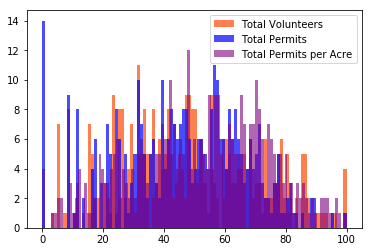

In [239]:
plt.hist(volunt_perms['tv_palmm'], bins=100, color='coral', label='Total Volunteers')
plt.hist(volunt_perms['tp_palmm'], bins=100, alpha=.7,color='blue', label= 'Total Permits')
plt.hist(volunt_perms['tpa_palmm'], bins=100, alpha=.6, color='purple', label= 'Total Permits per Acre')
plt.legend();

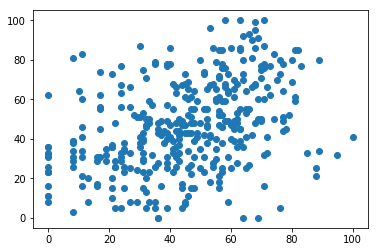

In [240]:
plt.scatter(volunt_perms['tp_palmm'],volunt_perms['tv_palmm']);

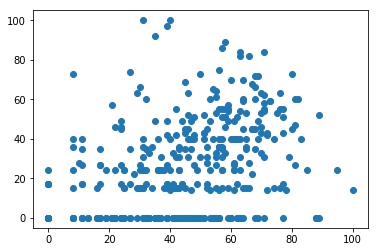

In [241]:
plt.scatter(volunt_perms['tp_palmm'],volunt_perms['tve_palmm']);

In [242]:
b1= {}
for i in park_types:
    b1[i]= volunt_perms[(volunt_perms['TYPECATEGO']==i)&(volunt_perms['tv_palmm']>=volunt_perms['tv_palmm'].quantile(.75))&(volunt_perms['tp_palmm']>=volunt_perms['tp_palmm'].quantile(.75))]['tv'].min()

In [243]:
b2= {}
for i in park_types:
    b2[i]= volunt_perms[(volunt_perms['TYPECATEGO']==i)&(volunt_perms['tve_palmm']>=volunt_perms['tve_palmm'].quantile(.75))&(volunt_perms['tp_palmm']>=volunt_perms['tp_palmm'].quantile(.75))]['tve'].min()

In [244]:
b3= {}
for i in park_types:
    b3[i]= volunt_perms[(volunt_perms['TYPECATEGO']==i)&(volunt_perms['lsp_palmm']>=volunt_perms['lsp_palmm'].quantile(.75))]['lsp'].min()

In [245]:
volunt_perms[(volunt_perms['lsp_palmm']>=volunt_perms['lsp_palmm'].quantile(.75))]['tp'].min()

2.0

In [246]:
volunt_perms[(volunt_perms['lsp_palmm']>=volunt_perms['lsp_palmm'].quantile(.75))]['tp'].max()
#There doesn't seem to be a clear link between permit events and stewardship.

5240.0

In [247]:
summ= pd.DataFrame(columns=volunt_perms.columns)
for i in park_types:
    summ= pd.concat([summ.copy(),volunt_perms[(volunt_perms['TYPECATEGO']==i)&(volunt_perms['tv']>=b1[i])].copy()],axis=0)
summ.shape
#The number of parks that pass this is 82 out of 364.

(82, 19)

In [248]:
summ2= pd.DataFrame(columns=volunt_perms.columns)
for i in park_types:
    summ2= pd.concat([summ2.copy(),volunt_perms[(volunt_perms['TYPECATEGO']==i)&(volunt_perms['tve']>=b2[i])].copy()],axis=0)
summ2.shape
#The number of parks that pass this is 96 out of 364.

(96, 19)

In [249]:
summ3= pd.DataFrame(columns=volunt_perms.columns)
for i in park_types:
    summ3= pd.concat([summ3.copy(),volunt_perms[(volunt_perms['TYPECATEGO']==i)&(volunt_perms['lsp']>=b3[i])].copy()],axis=0)
summ3.shape
#The number of parks that pass this is 93 out of 364.

(93, 19)

# Stewardship and Advocacy by Neighborhood
* using the benchmarks by park category, looks at the highest scoring parks for stewardship by neighborhood

In [259]:
volunt_perms[volunt_perms['GISPROPNUM'].isin(bayst['gispropnum'])][['lsp','tv']].sum()/2

lsp     28.0
tv     699.0
dtype: float64

In [260]:
summ3[(summ3['GISPROPNUM'].isin(bayst['gispropnum']))][['GISPROPNUM','SIGNNAME','TYPECATEGO','lsp','tv','tp','tp_palmm']]

,GISPROPNUM,SIGNNAME,TYPECATEGO,lsp,tv,tp,tp_palmm
179,R024,Tompkinsville Park,PP,10.0,472.0,32.0,53.0
356,R086,Davis Playground,PP,5.0,232.0,2.0,11.0
318,R123,Skyline Playground,NP,17.0,132.0,12.0,29.0
113,R022,Silver Lake Park,LP,21.0,481.0,340.0,55.0


In [261]:
volunt_perms[volunt_perms['GISPROPNUM'].isin(bushwick['gispropnum'])][['lsp','tv']].sum()/2

lsp     14.5
tv     385.5
dtype: float64

In [262]:
summ3[(summ3['GISPROPNUM'].isin(bushwick['gispropnum']))][['SIGNNAME','TYPECATEGO','lsp','tv','tp','tp_palmm']]

,SIGNNAME,TYPECATEGO,lsp,tv,tp,tp_palmm
58,Maria Hernandez Park,NP,7.0,118.0,411.0,70.0


In [263]:
volunt_perms[volunt_perms['GISPROPNUM'].isin(lic['gispropnum'])][['lsp','tv']].sum()/2

lsp     19.5
tv     699.0
dtype: float64

In [264]:
summ3[(summ3['GISPROPNUM'].isin(lic['gispropnum']))][['SIGNNAME','TYPECATEGO','lsp','tv','tp','tp_palmm']]

,SIGNNAME,TYPECATEGO,lsp,tv,tp,tp_palmm
70,Athens Square,PP,8.0,200.0,145.0,76.0
82,Hunter's Point South Park,LP,7.0,182.0,244.0,52.0


# ALL SCORES (to export)
* compiles a table of all scores with missing values for parks that can't be scored
* log min-max scores + original values
* useful any other type of analysis as all the scores (including volunteer scores) are in one place
* exports to: M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\190806_ALL_SCORES
* length is 1709
* __Columns:__
    - columns from the parks shapefile
    - 'tp'
    - 'tp_palmm'
    - 'tpa'
    - 'tpa_palmm'
    - 'tppop'
    - 'tppopdens'
    - 'tppop_palmm'
    - 'tppopdens_palmm'
    - 'tv'
    - 'tve'
    - 'tv_palmm'
    - 'tve_palmm'
    - 'lsp'
    - 'lsp_palmm'

In [304]:
parks.shape

(1709, 16)

In [310]:
perm_scores= perm_scores.drop('Unnamed: 0',axis=1)
perm_scores.shape

(825, 18)

In [339]:
# Merging parks and permitted event scores (columns TP AND TPA)
df1= pd.merge(parks,perm_scores[['GISPROPNUM','tp','tp_palmm','tpa','tpa_palmm']],on='GISPROPNUM',how='left')

In [340]:
df2= pd.merge(df1,scores2[['GISPROPNUM','tppop','tppopdens','tppop_palmm','tppopdens_palmm']],on='GISPROPNUM',how='left')

In [341]:
df3= pd.merge(df2,volunt_toscore.reset_index()[['GISPROPNUM','tv','tve','tv_palmm','tve_palmm']],on='GISPROPNUM',how='left')

In [342]:
df4= pd.merge(df3,no0.reset_index()[['GISPROPNUM','lsp','lsp_palmm']],on='GISPROPNUM',how='left')

In [348]:
df4.to_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\190806_ALL_SCORES\190806_ALLSCORES.csv")

In [349]:
df4.to_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\190806_ALL_SCORES\190806_ALLSCORES.shp")

In [344]:
df4.shape

(1709, 30)